In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Seasonal Autoregressive Integrated Moving Average
from statsmodels.tsa.ar_model import AutoReg # Auto Regressive
from statsmodels.tsa.arima.model import ARIMA # Autoregressive Integrated Moving Average
from statsmodels.tsa.api import VAR # Vector Autoregressive 
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test
from statsmodels.tsa.api import VARMAX # Vector AutoRegressive Moving Average Model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
import torch.optim as optim
from pylab import mpl

from prophet import Prophet # prophet model
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

# 设置正常显示符号
mpl.rcParams["axes.unicode_minus"] = False

# Time Series

## 1. 自回归（Auto Regressive, AR）

### 1.1 假设
自回归模型是一种时间序列分析模型，用于预测未来的值，其基本假设是序列的当前值是**其过去若干值的线性组合**。自回归模型在金融、经济、信号处理等领域中有广泛应用。

### 1.2 原理 
自回归模型假设时间序列$x_t$的值可以表示为之前$p$个时间点的加权和，加上一个误差项（随机扰动项)。

### 1.3 核心公式 
$$x_t = c + \phi_1x_{t-1} + \phi_1x_{t-2} + ··· + \phi_px_{t-p} + \epsilon_t$$
> * $x_t$:当前时间点的值
> * $c$:常数项
> * $\phi_1,\phi_2,···,\phi_p$:自回归系数
> * $p$: 模型的阶数
> * $\epsilon_t$:误差项，通常假设服从零均值正态分布$N(0,\sigma^2)$

### 1.3 公式推导 
假设有时间序列数据$x_1,x_2,...,x_n$，我们的目标是通过最小化预测值与实际值之间的误差平方和（即最小二乘法）来估计$\phi_1,\phi_2,...,\phi_p$的和。
1. **模型表示**:
   $$x_t = c + \sum_{i=1}^p\phi_ix_{t-i} + \epsilon_t$$

2. **构造函数**:
   $$L = \sum_{t=p+1}^n(\ x_t - c - \sum_{i=1}^p\phi_ix_{t-i})^2$$

3. **对$c,\phi_1, \phi_2,...,\phi_p$求偏导**：
对$c$:
$$\frac{\partial L}{\partial c} = -2\sum_{t=p+1}^n(\ x_t - c - \sum_{i=1}^p\phi_ix_{t-i})$$
对$\phi_j$:

$$\frac{\partial L}{\partial \phi_j} = -2\sum_{t=p+1}^nx_{t-j}(\ x_t - c - \sum_{i=1}^p\phi_ix_{t-i})$$

4. **解方程组**：  
 通过偏导方程组求解$c$和$\phi_i$，得到自回归模型的参数估计值

### 1.4 Demo

C:\Users\Yin\AppData\Local\Temp\ipykernel_28404\787128180.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


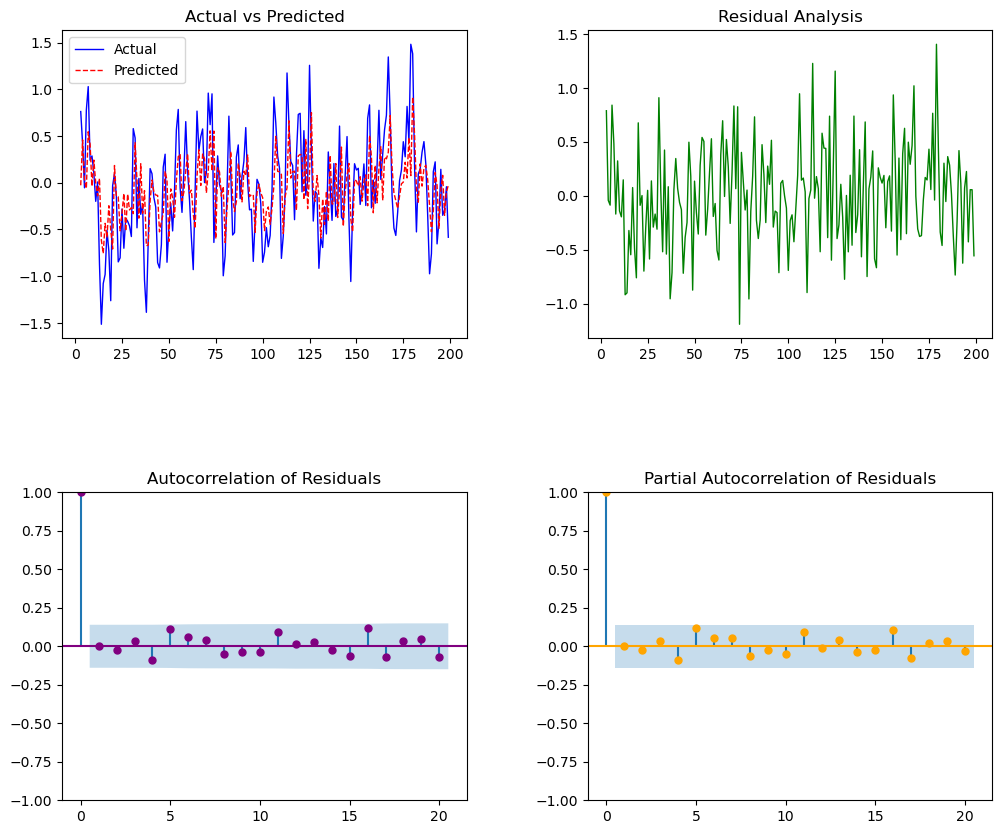

In [7]:
# 1. 生成虚拟时间序列数据
np.random.seed(42)
n = 200
phi = [0.7, -0.3, 0.2]  # AR(3) 系数
p = len(phi)
noise = np.random.normal(0, 0.5, n)  # 随机噪声
series = np.zeros(n)

# 根据 AR(3) 公式生成时间序列
for t in range(p, n):
    series[t] = phi[0] * series[t-1] + phi[1] * series[t-2] + phi[2] * series[t-3] + noise[t]

# 转换为 DataFrame
data = pd.DataFrame({"Time": range(n), "Value": series})

# 2. 拟合自回归模型
model = AutoReg(series, lags=p).fit()
predictions = model.predict(start=p, end=n-1)

# 3. 绘图
fig, axes = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

# (a) 时间序列实际值与预测值: 展示自回归模型的拟合效果。如果预测值紧跟实际值，说明模型捕捉了时间序列的主要趋势。
axes[0, 0].plot(data["Time"][p:], series[p:], label='Actual', color='blue', linewidth=1)
axes[0, 0].plot(data["Time"][p:], predictions, label='Predicted', color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title("Actual vs Predicted")
axes[0, 0].legend()

# (b) 残差分析:检查残差是否围绕零随机分布。发现异常模式或趋势可能提示模型不合适。 
residuals = series[p:] - predictions
axes[0, 1].plot(data["Time"][p:], residuals, color='green', linewidth=1)
axes[0, 1].set_title("Residual Analysis")

# (c) 自相关图:验证残差的自相关性。若残差无明显自相关，说明模型对数据的拟合较好。
plot_acf(residuals, ax=axes[1, 0], lags=20, color='purple')
axes[1, 0].set_title("Autocorrelation of Residuals")

# (d) 偏自相关图:分析残差中尚未解释的部分是否还有显著的线性相关性。有助于判断模型是否需要更高阶的改进。
plot_pacf(residuals, ax=axes[1, 1], lags=20, color='orange')
axes[1, 1].set_title("Partial Autocorrelation of Residuals")

# 显示
plt.tight_layout()
plt.show()

## 2. 移动平均回归 (Moving Average Model Regression , MAMR )

### 2.1 假设 
移动平均是一种简单而常用的时间序列分析方法，用于平滑数据或预测趋势。它通过计算**固定窗口内的数据平均值，减少数据中的短期波动，从而更好地揭示长期趋势**。

### 2.2 原理 
1. **平滑数据**：移动平均通过去掉短期波动，解释时间序列中的**长期趋势**。
2. **消除噪音**：对数据进行平滑处理，减小噪音对分析的干扰。
3. **灵活窗口**：窗口大小（滑动窗口的宽度）决定了平滑的程度。
   * 较小的窗口反应短期变化
   * 较大的窗口捕获长期趋势，但可能会导致滞后。

### 2.3 核心公式
给定一个时间序列$X ={x_1, x_2, ..., x_n}$, 移动平均的公式为： 
  
1. **简单移动平均（Simple Moving Average, SMA）**:      
   $$SMA_t = \frac{1}{k}\sum_{i = t - k + 1}^{t}x_t$$  
其中：
* $k$: 窗口大小
* $x_i$:时间序列的第$i$个值
* $SMA_t$:第$t$时刻的移动平均值
  
2.  **加权移动平均（Weighted Moving Average, WMA)**  
  $$WMA_t = \frac{\sum_{i=0}^{k-1}w_ix_{t-i}}{\sum_{i=0}^{k-1}w_i}$$

其中： 
* $w_i$：权重值，通常权重随着时间增加而减小。

3. **指数移动平均（Exponential Moving Average，EMA）**：
    EMA使用递归方式计算
   $$EMA_t = \alpha x_t + (1 -\alpha\ )EMA_{t-1}$$

其中： 
* $\alpha = \frac{2}{k+1}$:平滑系数
* $k$:窗口大小
* $EMA_{t-1}$:前一时刻EMA值

### 2.4 公式推导  
1. **简单易懂平均（SMA）**
对一个窗口大小为$k$的时间序列$X ={x_1, x_2, ..., x_n}$，第t时刻的 SMA 定义为窗口内所有值的均值：
 $$SMA_t = \frac{1}{k}\sum_{i = t - k + 1}^{t}x_t$$

2. **指数移动平均（EMA）**
EMA是一种递归算法， 推到如下：
> 1. 基础公式：  $$EMA_t = \alpha x_t + (\ 1 -\alpha\ )EMA_{t-1}$$
> 2. 假设初始值：$EMA_i = x_1$, 然后迭代计算。
> 3. 平滑系数$\alpha = \frac{1}{k+1}$,确保更大的$k$对旧数据赋予更大权重。
通过递归展开，可以写成
$$EMA_t = \alpha{x_t} + \alpha(1 - \alpha)x_{t-1} + \alpha(1 - \alpha)^2x_{t-2}+ ... $$

### 2.5 Demo 

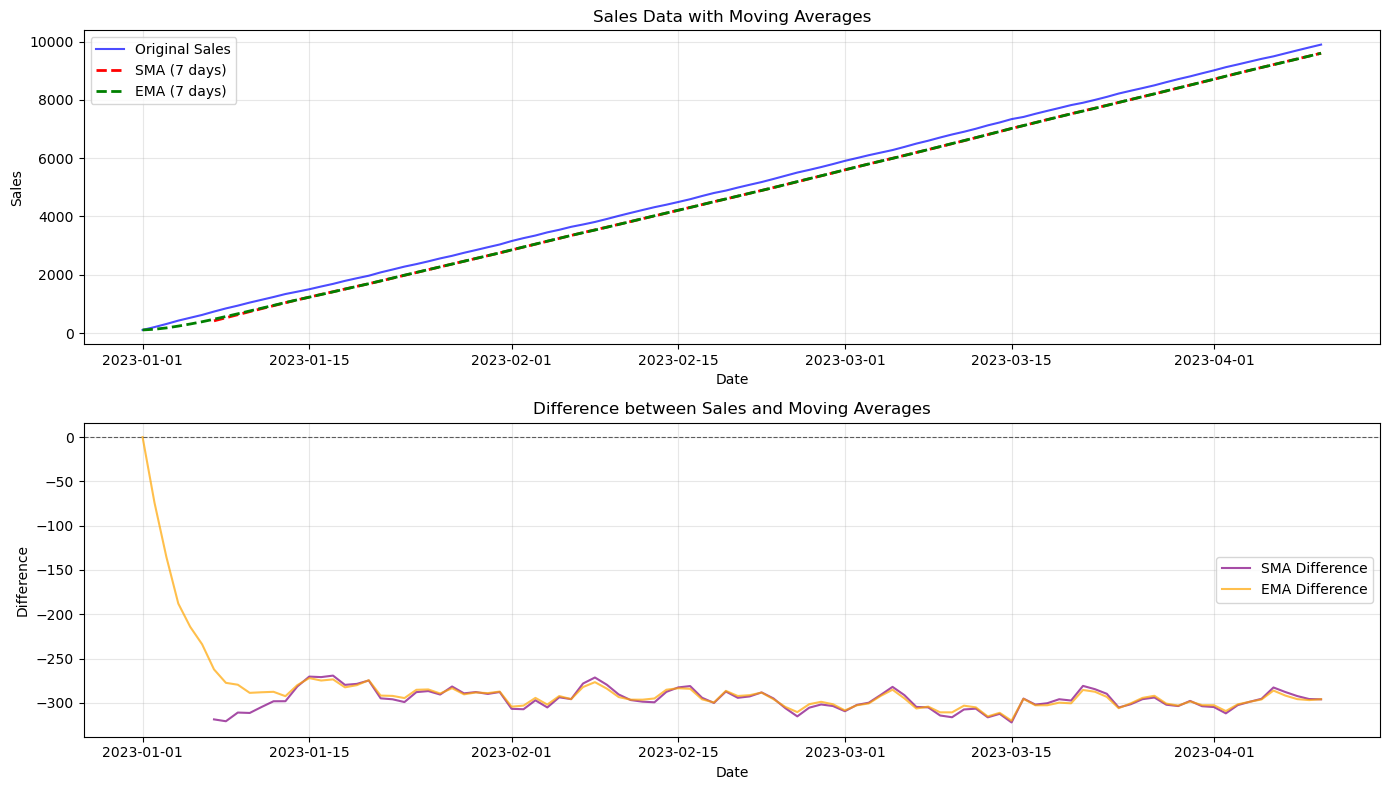

In [8]:
# 生成虚拟数据
np.random.seed(42)
days = 100
dates = pd.date_range("2023-01-01", periods=days)
sales = np.cumsum(np.random.randn(days) * 10 + 100)

# 构建数据框
df = pd.DataFrame({"Date": dates, "Sales": sales})
df.set_index("Date", inplace=True)

# 计算不同类型的移动平均
window_size = 7  # 窗口大小
df["SMA"] = df["Sales"].rolling(window=window_size).mean()  # 简单移动平均
df["EMA"] = df["Sales"].ewm(span=window_size, adjust=False).mean()  # 指数移动平均

# 绘制图形
plt.figure(figsize=(14, 8))

# 图1: 原始数据和移动平均: 展示原始数据的波动趋势，比较不同移动平均的平滑效果。清晰地展示了移动平均平滑后的曲线，以及窗口大小对结果的影响。
plt.subplot(2, 1, 1)
plt.plot(df.index, df["Sales"], label="Original Sales", color="blue", linewidth=1.5, alpha=0.7)
plt.plot(df.index, df["SMA"], label=f"SMA ({window_size} days)", color="red", linestyle="--", linewidth=2)
plt.plot(df.index, df["EMA"], label=f"EMA ({window_size} days)", color="green", linestyle="--", linewidth=2)
plt.title("Sales Data with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)

# 图2: 移动平均差异分析: 观察移动平均与原始数据的偏差，帮助理解平滑对原始数据的影响。突出平滑可能带来的滞后和对异常值的处理效果。
plt.subplot(2, 1, 2)
plt.plot(df.index, df["SMA"] - df["Sales"], label="SMA Difference", color="purple", linewidth=1.5, alpha=0.7)
plt.plot(df.index, df["EMA"] - df["Sales"], label="EMA Difference", color="orange", linewidth=1.5, alpha=0.7)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)
plt.title("Difference between Sales and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Difference")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 自回归积分移动平均(Autoregressive Integrated Moving Average, ARIMA)

### 3.1 假设
ARIMA（Auto-Regressive Integrated Moving Average）是一种经典的时间序列预测方法，适用于具有**趋势性和季节性波动的时间序列**。
* **自回归（AR）**:使时间序列自身的过去值来预测未来
* **积分（I）**：通过差分消除时间序列中的非平稳趋势
* **移动平均(MA)**：通过过去的预测误差(残差)进行修正

### 3.2 原理 
**ARIMA**模型建立在时间序列的**线性回归**假设基础上，其目标是通过AR，I和MA三个部分协同作用，捕捉序列的随机波动和趋势，以实现精准预测。

核心步骤包括： 
1. **时间序列平稳性检查**:通过差分或对数变换将非平稳序列转换为平稳序列。
2. **模型参数识别**：确定AR部分的阶数p,差分阶段d和MA部分的阶数q。
3. **模型拟合**:用最大似然估计法优化模型参数。
4. **预测与评估**:根据拟合模型进行未来数据预测，并使用AIC/BIC等指标评估模型性能

### 3.3 核心公式 
1. 自回归（AR）
   $$X_t = \phi_1X_{t-1} + \phi_2X_{t-2} + ... + \phi_pX_{t-p} + \epsilon_t$$
* $X_t$: 当前值
* $\phi_i$:自回归系数
* $\epsilon_t$:误差项

2. 移动平均（MA）
   $$ X_t = \epsilon_t + \theta_1\epsilon_{t-1} + ··· + \theta_q\epsilon_{t-q}$$
* $\theta_i$:移动平均

3. 完整ARIMA模型
   $$\Delta^dX_t = (\phi_1\Delta^dX_{t-1} + ··· + \phi_p\Delta^dX_{t-p} )+ (\epsilon_t +\theta_1\epsilon_{t-1} + ··· + \theta_q\epsilon_{t-q})$$
* $\Delta^d$:差分运算
* $d$:差分次数

### 3.4 公式推导 
以ARIMA（1,1，1）为例： 
1. **原始序列差分**: $Y_t = X_t - X_{t-1}$以消除非平稳性
2. **引入AR和MR关系**: $Y_t = \phi_1Y_{t-1} + \epsilon_t + \theta_1\epsilon_{t-1}$
3. **回代得到预测公式**：$X_t = X_{t-1} + \phi_1(X_{t-1} - X_{t-2} + \epsilon_t +\theta_1\epsilon_{t-1})$

### 3.5 Demo

C:\Users\Yin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Yin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


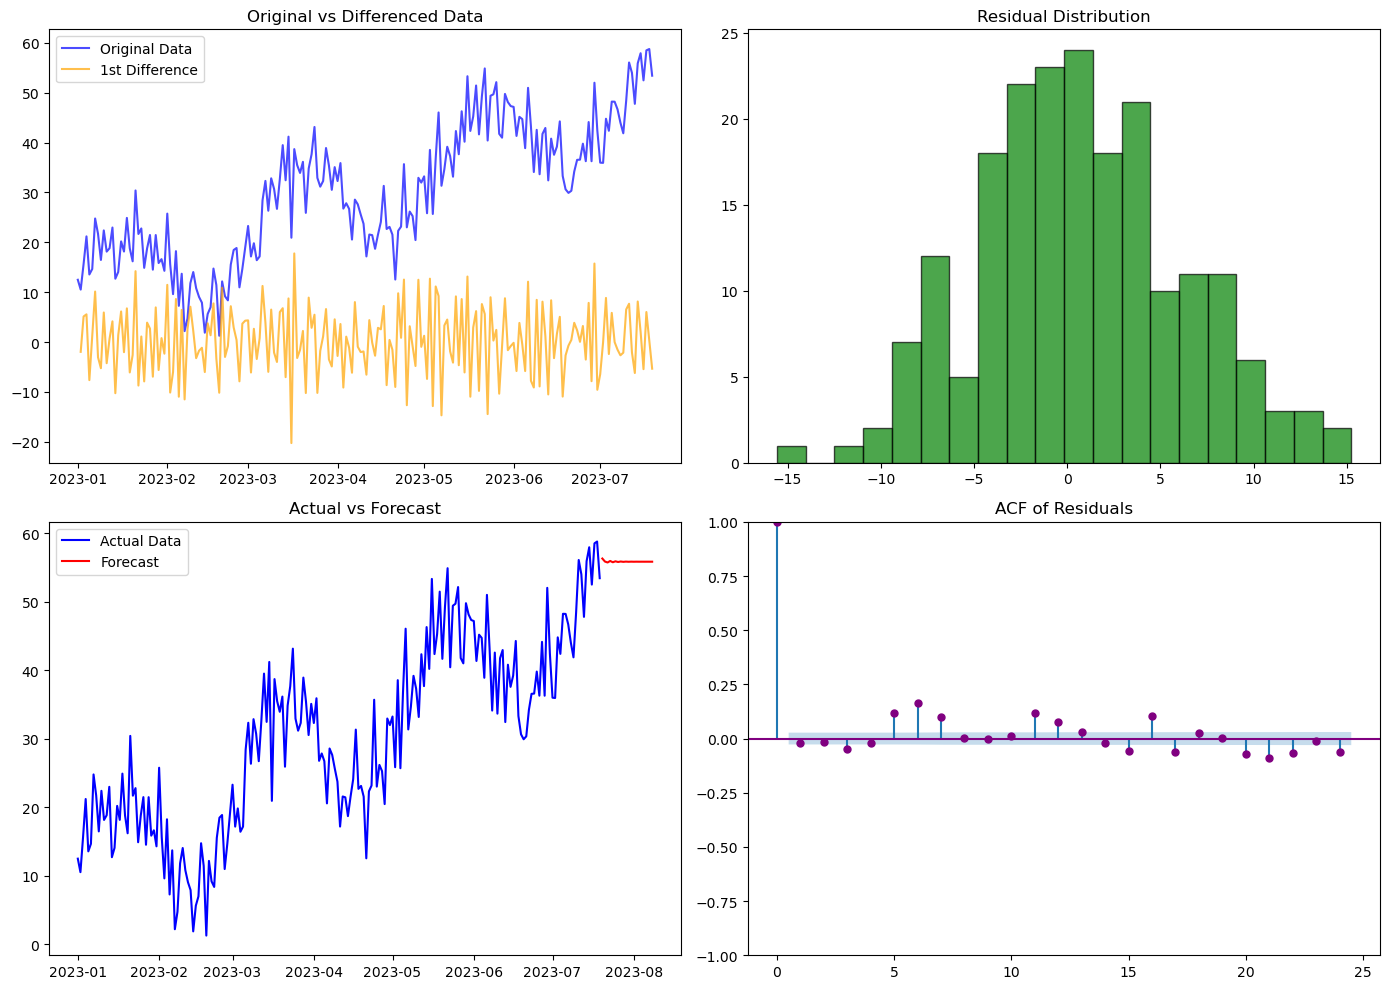

In [10]:
# 生成虚拟时间序列数据
np.random.seed(42)
n = 200
trend = np.linspace(10, 50, n)  # 趋势项
seasonal = 10 * np.sin(np.linspace(0, 20, n))  # 季节性项
noise = np.random.normal(0, 5, n)  # 噪声项
data = trend + seasonal + noise
dates = pd.date_range(start='2023-01-01', periods=n)

# 创建 DataFrame
df = pd.DataFrame({'Date': dates, 'Value': data})
df.set_index('Date', inplace=True)

# 差分处理（1阶差分）
df['Diff'] = df['Value'].diff()

# 拟合 ARIMA 模型
model = ARIMA(df['Value'], order=(2, 1, 2))
fit = model.fit()

# 预测未来值
forecast_steps = 20
forecast = fit.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=dates[-1], periods=forecast_steps + 1)[1:]

# 绘图
plt.figure(figsize=(14, 10))

# 子图1: 原始数据和差分数据: 直观地展示数据的平稳性差异，验证模型的平稳性假设。
plt.subplot(2, 2, 1)
plt.plot(df.index, df['Value'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df.index, df['Diff'], label='1st Difference', color='orange', alpha=0.7)
plt.title('Original vs Differenced Data')
plt.legend()

# 子图2: 拟合值与真实值的残差: 检查模型的拟合效果，验证误差是否符合正态分布。
plt.subplot(2, 2, 2)
residuals = fit.resid
plt.hist(residuals, bins=20, color='green', alpha=0.7, edgecolor='black')
plt.title('Residual Distribution')

# 子图3: 实际值与预测值: 展示模型预测的准确性。
plt.subplot(2, 2, 3)
plt.plot(df.index, df['Value'], label='Actual Data', color='blue')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.title('Actual vs Forecast')
plt.legend()

# 子图4: ACF 图: 分析残差的自相关性，判断是否存在模型未捕获的信息。
plt.subplot(2, 2, 4)
plot_acf(residuals, ax=plt.gca(), color='purple', alpha=0.7)
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

## 4. 季节性自回归积分移动平均(Seasonal ARIMA, SARIMA)

### 4.1 假设 
SARIMA（Seasonal Autoregressive Integrated Moving Average）是一种时间序列分析和预测的统计模型，用于捕获时间序列数据中的**自相关性和季节性**模式。SARIMA 是 ARIMA 模型的扩展，增加了处理周期性波动的能力。

SARIMA 模型的核心思想是将时间序列分解为**趋势、季节性、周期性和随机波动**，并针对每部分建立预测模型。SARIMA 被广泛应用于金融、气候预测、销售数据分析等领域。

### 4.2 原理  
SARIMA 模型包括以下参数：

$p,d,q$：对应 ARIMA 模型中的自回归阶数、差分次数、移动平均阶数。  
$P,D,Q,s$：捕捉季节性模式的参数，分别是季节性自回归阶数、季节性差分次数、季节性移动平均阶数和季节周期长度。

模型的目标是通过最小化预测误差来找到最佳参数组合，从而进行时间序列预测。

### 4.3 核心公式   
$$\Phi_P(B^s)\phi_P(B)(1-B^s)^DY_t = \Theta_Q(B^s)\theta_1(B)\epsilon_t$$ 

其中： 
* $B$:滞后算子（BY_t = Y_{t-1}）
* $\phi_p(B)$:非季节性自回归多项式
* $\Phi_P(B^s)$:季节性自回归多项式
* $\theta_q(B)$:非季节性移动平均多项式
* $\Theta_Q(B^s)$:季节性移动平均多项式
* $(1-B)^d$:非季节性差分算子
* $(1-B^n)^D$:季节性差分算子



### 4.5 公式推导
1. 差分处理： 通过$(1 - B)^d$ 和$(1-B^s)^D $消除非季节性和季节性趋势
2. 自回归部分： 通过$\phi_p(B)$和$\Phi_P(B^s)$ 描述当前值与过去值的关系
3. 移动平均部分： 通过$\theta_q(B)$和$\Theta_Q(B^s)$ 捕捉残差的相关性

### 4.4 Demo 

C:\Users\Yin\AppData\Local\Temp\ipykernel_28404\2544606185.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2024-01-01', periods=n_periods, freq='M')
C:\Users\Yin\AppData\Local\Temp\ipykernel_28404\2544606185.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=30), periods=forecast_steps, freq='M')


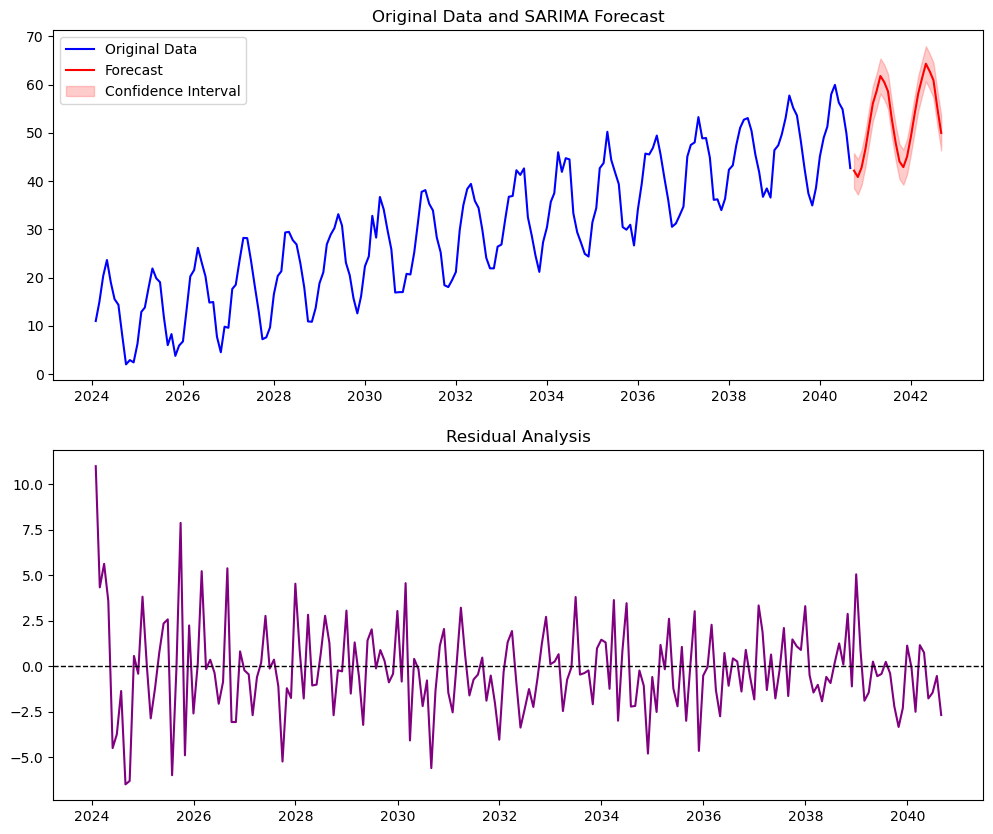

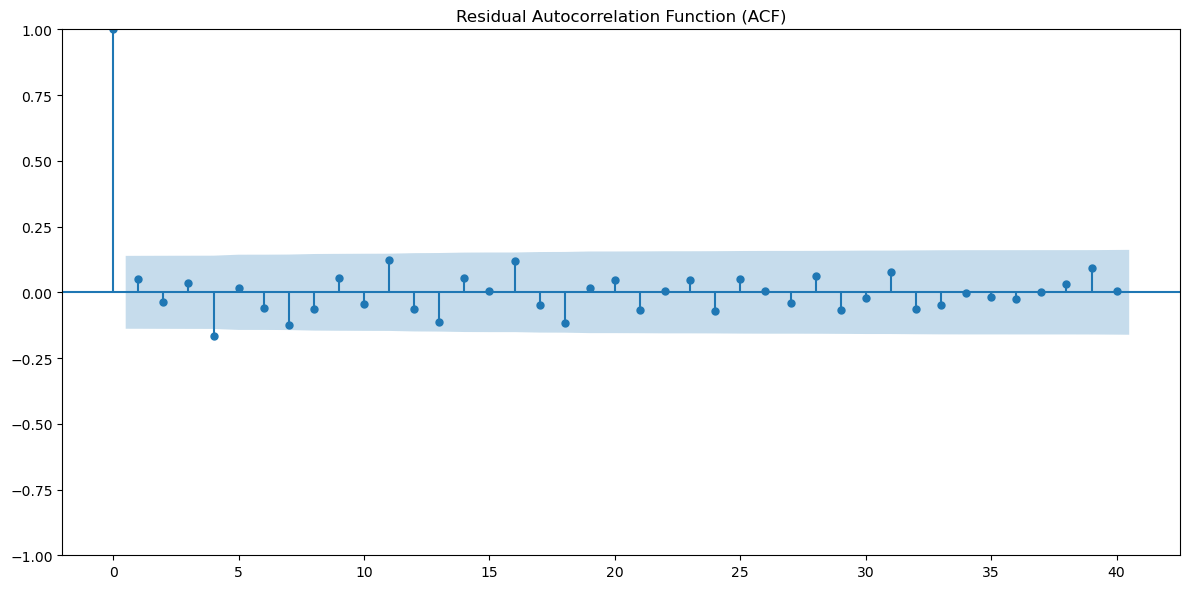

In [12]:

# 1. 创建虚拟数据集
np.random.seed(42)
n_periods = 200
season_length = 12
trend = np.linspace(10, 50, n_periods)  # 线性趋势
seasonality = 10 * np.sin(2 * np.pi * np.arange(n_periods) / season_length)  # 季节性
noise = np.random.normal(0, 2, n_periods)  # 噪声
data = trend + seasonality + noise
dates = pd.date_range(start='2024-01-01', periods=n_periods, freq='M')
time_series = pd.Series(data, index=dates)

# 2. 拟合 SARIMA 模型
model = SARIMAX(time_series, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, season_length), 
                enforce_stationarity=False, 
                enforce_invertibility=False)
results = model.fit()

# 3. 模型预测
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=30), periods=forecast_steps, freq='M')
forecast_series = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# 4. 残差分析
residuals = results.resid

# 5. 图像绘制
fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=100)

# (a) 原始数据与预测对比
axes[0].plot(time_series, label='Original Data', color='blue')
axes[0].plot(forecast_index, forecast_series, label='Forecast', color='red')
axes[0].fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                     color='red', alpha=0.2, label='Confidence Interval')
axes[0].set_title('Original Data and SARIMA Forecast')
axes[0].legend(loc='upper left')

# (b) 残差时间序列
axes[1].plot(residuals, label='Residuals', color='purple')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Residual Analysis')

# 残差 ACF 图（另开窗口绘制）
fig_acf, ax_acf = plt.subplots(figsize=(12, 6), dpi=100)
plot_acf(residuals, ax=ax_acf, lags=40)
ax_acf.set_title('Residual Autocorrelation Function (ACF)')

# 显示所有图形
plt.tight_layout()
plt.show()

## 5. 向量自回归 (Vector Autoregressive Model, VAR)

### 5.1 假设
向量自回归（VAR）是一种统计模型，用于描述**多个时间序列变量**之间的动态关系。它是多元时间序列分析的重要工具，用于同时建模多个变量之间的相互影响。VAR不需要区分**因变量**和**自变量**，所有变量被视为内生变量。

### 5.2 原理 

VAR 模型假定每个变量的当前值是其**自身滞后值以及其他变量滞后值的线性函数**。其目标是捕获时间序列数据之间的线性关系，从而对变量进行预测或因果分析。

VAR 的核心假设是变量之间的线性关系稳定，并且残差项是白噪声。

### 5.3 核心公式 
对于$k$个时间序列变量$y_1,y_2,...,y_n$，设每个序列的长度为T，VAR(p) 模型表示为：
$$Y_t = c + \sum_{i=1^p}^p\Theta_iY_{t-i} + \epsilon_t$$  
* $Y_t = [\ y_{1t},y_{2t},...,y_{nt}\ ]^T$:当前时刻t的k个变量组成的列向量。
* $c$:常数向量。
* $\Theta_i$: 维度为$k \times k$的系数矩阵，标识滞后i时刻对当前值的影响。
* $\epsilon_i$:误差向量，假定为零均值、无自相关、同方差的白噪音。

### 5.4 公式推导   
对于单变量AR（p)模型： 
$$y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2}+...+ \phi_py_{t-p} +\epsilon_t$$
将其推广到多变量Y_t,用矩阵形式表示。对于p滞后性，VAR（p)完整表示如下： 
<img src ="../images/VAR.png">   
通过最小二乘法和最大似然估计对系数矩阵$\Theta_i$,和常量系数$c$进行估计。

### 5.5 Demo

平稳性检验结果: {'y1': 4.660249139935647e-10, 'y2': 3.976498365335371e-12}


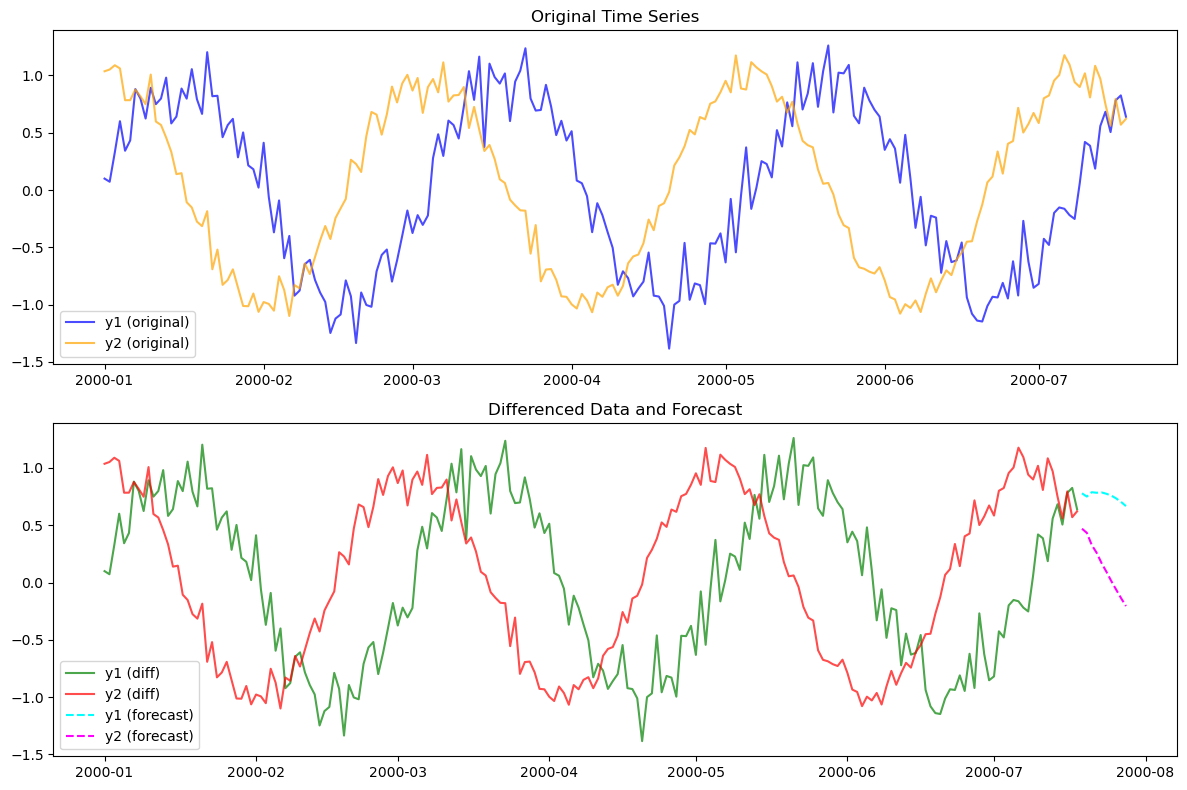

In [17]:
# 1. 创建虚拟时间序列数据
np.random.seed(42)
n_obs = 200

# 生成变量 y1 和 y2
time = np.arange(n_obs)
y1 = np.sin(0.1 * time) + np.random.normal(scale=0.2, size=n_obs)  # 波动的正弦序列
y2 = np.cos(0.1 * time) + 0.5 * np.random.normal(scale=0.2, size=n_obs)  # 波动的余弦序列

# 创建数据框
data = pd.DataFrame({'y1': y1, 'y2': y2})
data.index = pd.date_range(start='2000-01-01', periods=n_obs, freq='D')

# 2. 检查平稳性
def check_stationarity(series):
    result = adfuller(series)
    return result[1]  # 返回 p 值

stationarity_results = {col: check_stationarity(data[col]) for col in data.columns}
print("平稳性检验结果:", stationarity_results)

# 如果不平稳，可以对数据进行差分
if any(p_val > 0.05 for p_val in stationarity_results.values()):
    data_diff = data.diff().dropna()
else:
    data_diff = data

# 3. 构建 VAR 模型
model = VAR(data_diff)
results = model.fit(2)  # 滞后阶为 2

# 4. 模型预测
forecast_steps = 10
forecast = results.forecast(data_diff.values[-results.k_ar:], steps=forecast_steps)
forecast_index = pd.date_range(data_diff.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['y1_forecast', 'y2_forecast'])

# 5. 数据可视化
plt.figure(figsize=(12, 8))

# 原始数据与差分数据：展示变量的整体趋势和周期性波动。帮助判断变量是否平稳。
plt.subplot(2, 1, 1)
plt.plot(data.index, data['y1'], label='y1 (original)', color='blue', alpha=0.7)
plt.plot(data.index, data['y2'], label='y2 (original)', color='orange', alpha=0.7)
plt.title('Original Time Series')
plt.legend()

# 差分数据与预测结果：差分数据图展示平稳化后的趋势，有助于进一步建模。预测结果图直观展示模型性能，观察未来变量可能的变化。
plt.subplot(2, 1, 2)
plt.plot(data_diff.index, data_diff['y1'], label='y1 (diff)', color='green', alpha=0.7)
plt.plot(data_diff.index, data_diff['y2'], label='y2 (diff)', color='red', alpha=0.7)
plt.plot(forecast_df.index, forecast_df['y1_forecast'], label='y1 (forecast)', linestyle='--', color='cyan')
plt.plot(forecast_df.index, forecast_df['y2_forecast'], label='y2 (forecast)', linestyle='--', color='magenta')
plt.title('Differenced Data and Forecast')
plt.legend()

plt.tight_layout()
plt.show()

## 6. 向量自回归移动平均(Vector Autoregression Moving Average with Exogenous Regressors,VARMAX)

### 6.1 假设 
  
向量自回归移动平均模型（VARMA, Vector AutoRegressive Moving Average Model）是时间序列分析中的一种多变量扩展模型。它结合了**自回归模型（VAR）** 和 **移动平均模型（VMA）** 的特点，能够同时建模多个时间序列之间的相互依赖关系。

### 6.2 原理
VARMA 模型由两个主要部分组成：

1. 向量自回归（VAR）部分： 表示当前值与过去几个时刻自身值及其他变量值的线性关系。
2. 移动平均（MA）部分： 表示当前值与过去几个时刻的误差项的线性关系。
$$y_t = \sum_{i=1}^pA_iy_{t-1} + \sum_{j=1}^qB_j\epsilon_{t-j} + \epsilon_t$$
* $y_t$:$k$ 一维时间序列向量
* $p,q$:自回归和移动平均的阶数
* $A_i, B_i$:系数矩阵，表示变量间的相互影响
* $\epsilon_t$:$k$ 一维白噪声误差向量

### 6.3 核心公式 
VARMA关键是估计参数矩阵$A_I$和$B_j$以VARMA（1,1）模型为例，形式为： 
$$y_t = \sum_{i=1}^pA_iy_{t-1} + \sum_{j=1}^qB_j\epsilon_{t-j} + \epsilon_t$$
可以通过最大似然估计（MLE）求解： 
1. 假设误差项$\epsilon_t$服从正态分布，构建对数似然函数：
   $$lnL = \frac{T}{2}ln|\Sigma| - \frac{1}{2}\sum_{t=1}^T(\epsilon_t^T\Sigma^{-1}\epsilon_t)$$
   其中$\sum$是误差项的协方差矩阵
2. 求解对数似然函数的偏导数，对参数矩阵进行优化
3. 迭代估计$A_i$和$B_j$直到收敛

C:\Users\Yin\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\Yin\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


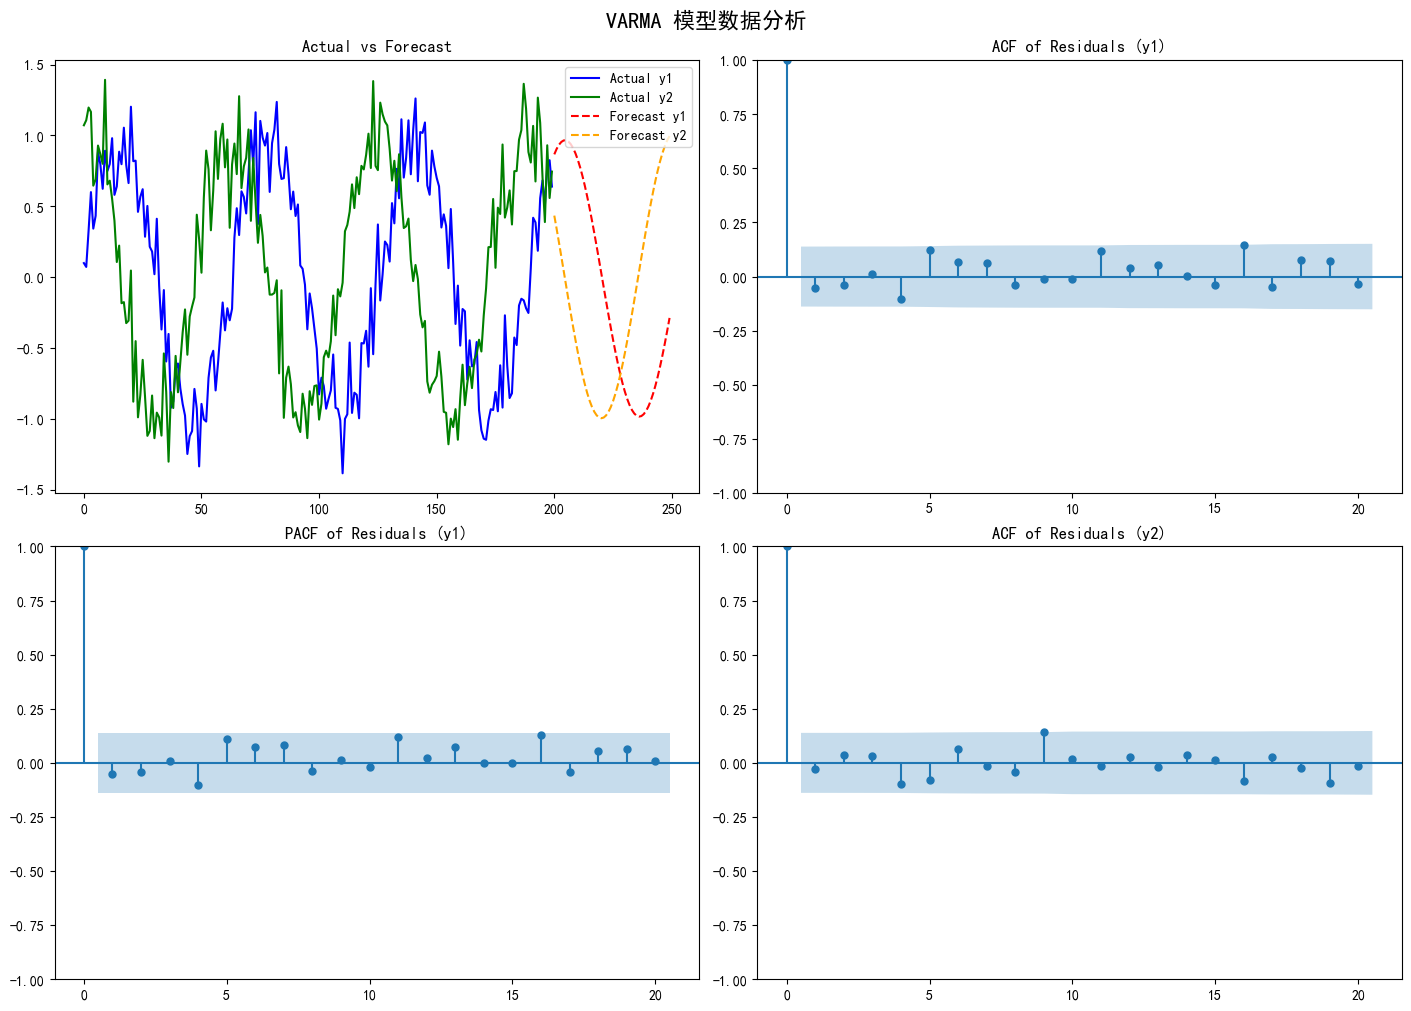

In [21]:
# 生成虚拟数据集
np.random.seed(42)
n_obs = 200
time = np.arange(n_obs)

# 构造两个相关联的时间序列
y1 = np.sin(0.1 * time) + np.random.normal(scale=0.2, size=n_obs)
y2 = np.cos(0.1 * time) + np.random.normal(scale=0.2, size=n_obs)
data = pd.DataFrame({'y1': y1, 'y2': y2})

# 拟合 VARMA(1,1) 模型
model = VARMAX(data, order=(1, 1))
results = model.fit(disp=False)

# 预测
n_forecast = 50
forecast = results.get_forecast(steps=n_forecast)
forecast_index = np.arange(n_obs, n_obs + n_forecast)
forecast_data = forecast.predicted_mean

# 绘图
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
fig.suptitle("VARMA 模型数据分析", fontsize=16)

# 实际值与预测值比较
axes[0, 0].plot(data.index, data['y1'], label='Actual y1', color='blue')
axes[0, 0].plot(data.index, data['y2'], label='Actual y2', color='green')
axes[0, 0].plot(forecast_index, forecast_data['y1'], label='Forecast y1', color='red', linestyle='dashed')
axes[0, 0].plot(forecast_index, forecast_data['y2'], label='Forecast y2', color='orange', linestyle='dashed')
axes[0, 0].set_title('Actual vs Forecast')
axes[0, 0].legend()

# 残差自相关图
residuals = results.resid
plot_acf(residuals['y1'], ax=axes[0, 1], lags=20, title='ACF of Residuals (y1)')
plot_pacf(residuals['y1'], ax=axes[1, 0], lags=20, title='PACF of Residuals (y1)')

# 自相关图
plot_acf(residuals['y2'], ax=axes[1, 1], lags=20, title='ACF of Residuals (y2)')

plt.show()

## 7. 长短期记忆网络 (Long Short-Term Memory,LSTM)

### 7.1 假设
LSTM（Long Short-Term Memory）是一种改进的递归神经网络（RNN），主要用于处理和预测时间序列数据。RNN 在处理长序列时容易出现梯度消失或梯度爆炸问题，而 LSTM 通过引入「门机制」来有效地解决这些问题。

### 7.2 原理
LSTM 的核心是其单元结构，由**遗忘门、输入门**和 **输出门**组成。它们通过控制信息的**流入、流出和遗忘**，使模型能够选择性地记住或忘记信息。
1. 遗忘门（Forget Gate）
   控制是否保留之前时间步的记忆。
   $$f_t = \sigma(W_f[\ h_{t-1}, \ x_t] + b_f)$$
* $f_t$:遗忘门的输出(0~1之间的值)
* $W_f, b_f$：遗忘门的权重和偏置
* $h_{t-1}$: 前一时刻的隐状态
* $x_t$:当前时间步的输入

2. 输入门(Input Gate)
控制当前输入对记忆的更新。
$$ i_t = \sigma(W_i[\ h_{t-1}, x_t] + b_I)$$
新记忆候选值：
$$\overline C_t = tanh(Wc[\ h_{t-1}, x_t] + b_C)$$
更新后的记忆：
$$C_t = f_t C_{t-1} + i_t\overline C_t$$

3. 输出门(Output Gate)
决定当前时间步的输出值
$$o_t = \sigma(W_o[h_{t-1}, x_t] + b_o)$$

输出隐状态： 
$$h_t = o_t tanh(C_t)$$

### 7.3 核心公式 
状态更新公式的推导：

1. 在时间步$t$，结合遗忘门输出$f_t$ ，对上一时间步的记忆$C_{t-1}$进行加权保留。
2. 输入门$i_t$与当前候选值$\overline C_t$相乘以选择性地更新当前时间步的记忆。
3. 隐状态$h_t$是当前记忆$C_t$的激活版本，乘以输出门$o_t$。

通过这些公式，LSTM 能够捕获长时依赖，并在适当的时间步上引入或丢弃信息。

### 7.4 Demo


C:\Users\Yin\AppData\Local\Temp\ipykernel_28404\15360143.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(x), torch.tensor(y)


Epoch [10/50], Train Loss: 0.4629, Test Loss: 0.4556
Epoch [20/50], Train Loss: 0.3583, Test Loss: 0.3416
Epoch [30/50], Train Loss: 0.0694, Test Loss: 0.0418
Epoch [40/50], Train Loss: 0.0226, Test Loss: 0.0255
Epoch [50/50], Train Loss: 0.0213, Test Loss: 0.0195


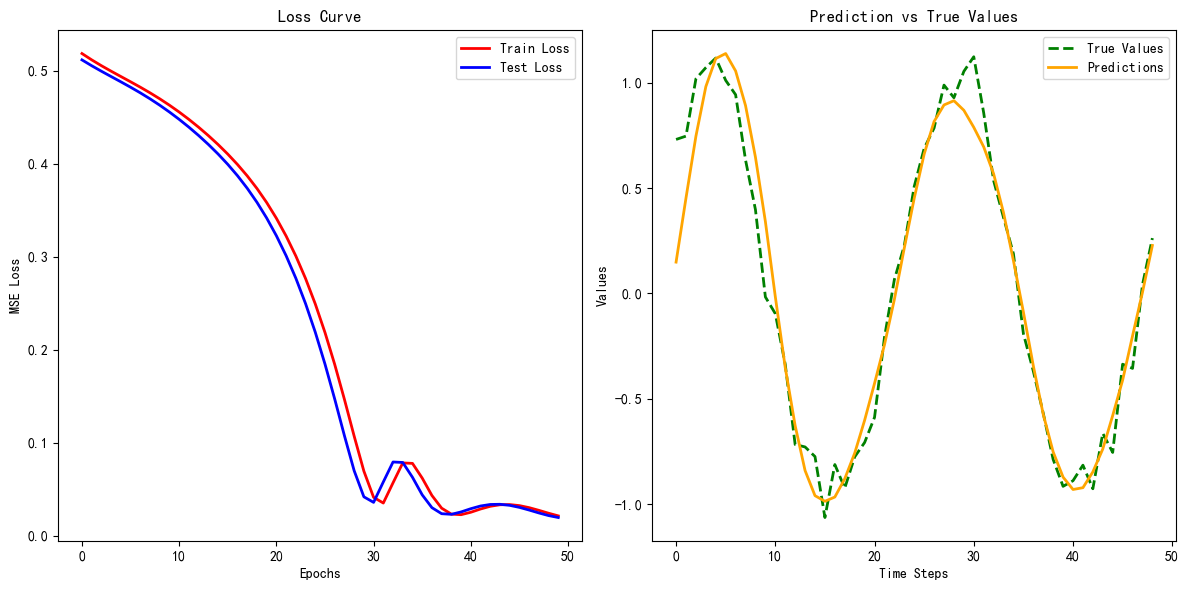

In [26]:
# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# ==== 数据生成 ====
# 模拟时间序列数据：正弦波 + 随机噪声
def generate_data(seq_length=50, num_samples=1000):
    x = np.linspace(0, 4 * np.pi, seq_length)
    data = [np.sin(x + np.random.uniform(-0.5, 0.5)) + 0.1 * np.random.randn(seq_length) for _ in range(num_samples)]
    return np.array(data, dtype=np.float32)

seq_length = 50
num_samples = 1000
data = generate_data(seq_length, num_samples)

# 数据分割
train_data = data[:800]
test_data = data[800:]

# ==== 数据预处理 ====
def create_sequences(data, seq_length):
    x, y = [], []
    for seq in data:
        x.append(seq[:-1])  # 前 n-1 作为输入
        y.append(seq[1:])   # 后 n-1 作为输出
    return torch.tensor(x), torch.tensor(y)

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# ==== 定义 LSTM 模型 ====
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# 超参数
input_size = 1
hidden_size = 64
num_layers = 2
learning_rate = 0.001
num_epochs = 50

# 初始化模型
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# ==== 模型训练 ====
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train.unsqueeze(-1))  # 增加输入维度 (batch, seq_len, input_size)
    loss = criterion(outputs.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # 验证损失
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test.unsqueeze(-1))
        test_loss = criterion(test_outputs.squeeze(), y_test)
        test_losses.append(test_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# ==== 数据可视化 ====
# 1. 训练和测试损失曲线 清晰展示训练和验证过程中的模型收敛情况。帮助判断是否存在过拟合（训练损失低但测试损失高）或欠拟合（训练和测试损失均高）。
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='red', linewidth=2)
plt.plot(test_losses, label='Test Loss', color='blue', linewidth=2)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

# 2. 测试集预测结果与真实值对比： 验证模型在时间序列任务中的拟合能力。可直观观察模型预测的趋势与实际数据的吻合程度。
with torch.no_grad():
    test_pred = model(x_test.unsqueeze(-1)).squeeze()

plt.subplot(1, 2, 2)
plt.plot(y_test[0].numpy(), label='True Values', color='green', linestyle='--', linewidth=2)
plt.plot(test_pred[0].numpy(), label='Predictions', color='orange', linewidth=2)
plt.title('Prediction vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()



## 8. 变分自动编码器(Variational Auto-Encoders, VAE)

### 8.1 假设 
变分自动编码器（VAE）是一种生成模型，它在经典自动编码器的基础上引入了**概率建模**的思想。VAE主要用于**学习数据的潜在分布，并能够生成与输入数据分布相似的新样本**。其核心目标是通过一个潜在变量（latent variable）对复杂数据分布进行建模。

### 8.2 核心思想 
1. 使用神经网络对复杂数据分布进行建模。
2. 将数据映射到一个低维潜在空间，假设潜在空间服从简单的分布（如正态分布）。
3. 从潜在空间中采样，并通过解码器生成新数据。

### 8.3 变分推断 
由于直接计算数据分布$p(x)$是不可行的，VAE引入变分推断来近似后验分布$p(z|\ x)$。具体地，VAE利用一个参数化的分布 $q(z|\ x)$来近似$p(z|\ x)$，并通过最大化基于证据下界（Evidence Lower Bound, ELBO）的目标来训练模型。

### 8.4 核心公式 
1. 目标函数
   $$logp(x) >= E_{q(z|\ x)}[\ logp(x|\ z)] -D_{KL}(q(z\vert\ x)\|\ p(z))$$
* $E_{q(z|x)}[\ logp(x|\ z)] $: 重构误差（生成样本与真实样本的距离）
* $D_{KL}(q(z|\ x)\|\ p(z))$是KL散度，用于限制$q(z|x)$接近$p(z)$.

2. 重参数化技巧： 为了使q(z|x)可微，使用重参数化技巧:
   $$z = \mu + \sigma  \epsilon$$
其中 $\mu$和$\sigma$是由编码器输出的参数。

3. 损失函数
$$\iota = E_{q(z|x)}[\log p(x|\ z)] - D_{KL}(q(z\vert \ x)\|p(z))$$
其中, q(z|x)通常被建模为正态分布$N(\mu,\sigma^2)$.

### 8.5 公式推导
1. 数据边际对数似然
   $$logp(x) = \int p(x,z)dz = \int p(x|\ z)p(z)dz$$

2. 引入$q(z|\ x)$,通过$\log p(x)$的变形：
$$\log p(x) = \int q(z|\ x)\frac{p(x,z)}{q(z|\ x)}dz = E_{q(z|\ x)}\begin{bmatrix}\log\frac{p(x,\ z)}{q(z|\ x)} \end{bmatrix}$$

3. 分解：
$$\log{p(x)} = E_{q(z|\ x)}[\log p(x|\ z)] - D_{KL}(q(z| \ x)\|p(z)) + D_{KL}(q(z|\ x)\|p(z|\  x))$$

因为$D_{KL}(q(z|\ x)|p(z| \ x))>=0$，因此：
$$\log{p(x)}>=E_{q(z|\ x)}[\log{p(x|\ z)}] - D_{KL}(q(z|x)\|p(z))$$

### 8.6 Demo 

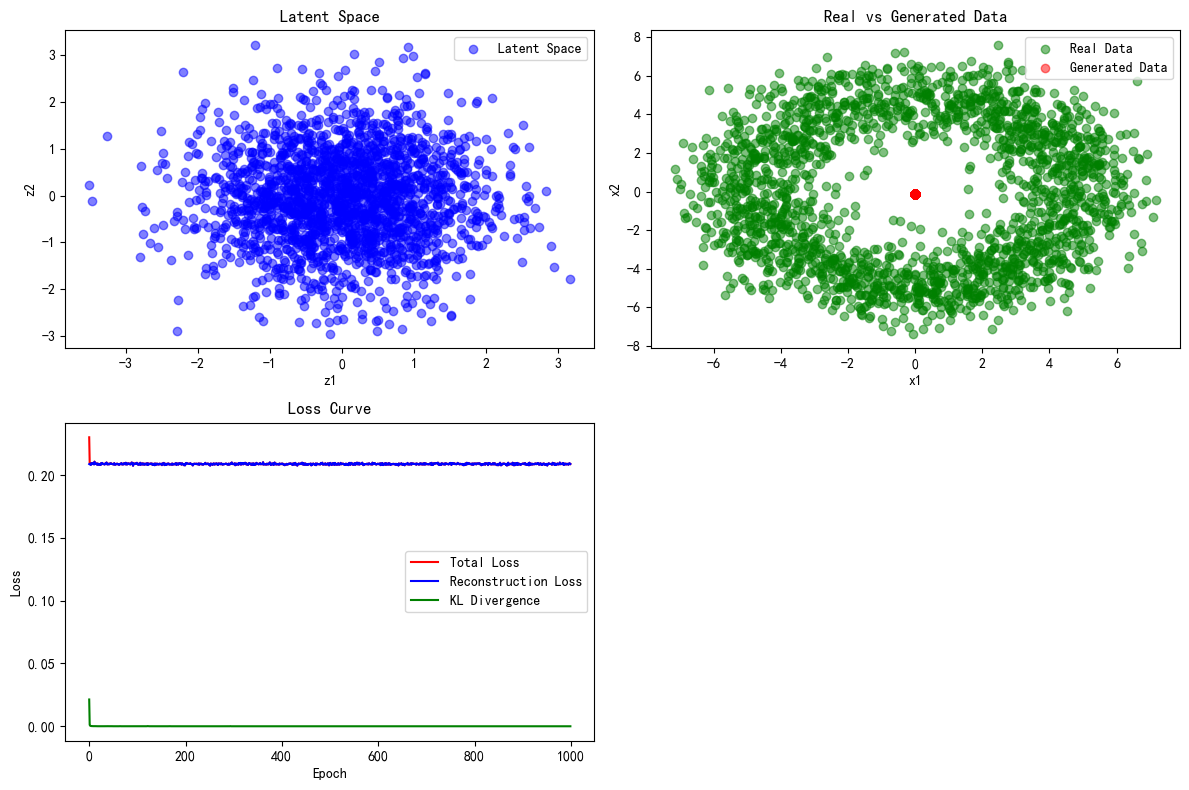

In [28]:
# 数据生成：二维环形数据
def generate_data(num_samples=2000):
    theta = 2 * np.pi * np.random.rand(num_samples)
    r = 5 + np.random.randn(num_samples)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.stack([x, y], axis=1)

# 定义VAE模型
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# 损失函数
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = nn.MSELoss()(x_recon, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# 数据加载
data = generate_data()
data_tensor = torch.tensor(data, dtype=torch.float32)

# 模型训练
vae = VAE(input_dim=2, latent_dim=2)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
num_epochs = 1000
batch_size = 64

losses, recon_losses, kl_divs = [], [], []
for epoch in range(num_epochs):
    perm = np.random.permutation(len(data))
    epoch_loss, epoch_recon_loss, epoch_kl_div = 0, 0, 0
    for i in range(0, len(data), batch_size):
        batch = data_tensor[perm[i:i+batch_size]]
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(batch)
        loss = vae_loss(batch, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_recon_loss += nn.MSELoss()(x_recon, batch).item()
        epoch_kl_div += -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()).item()
    losses.append(epoch_loss / len(data))
    recon_losses.append(epoch_recon_loss / len(data))
    kl_divs.append(epoch_kl_div / len(data))

# 生成数据分析图
with torch.no_grad():
    z_samples = torch.randn(1000, 2)
    generated_data = vae.decode(z_samples).numpy()

plt.figure(figsize=(12, 8))

# 图1：潜在空间: 说明数据如何被映射到潜在空间中，以及潜在表示的分布情况。
plt.subplot(2, 2, 1)
mu, logvar = vae.encode(data_tensor)
z = vae.reparameterize(mu, logvar).detach().numpy()
plt.scatter(z[:, 0], z[:, 1], c='blue', alpha=0.5, label='Latent Space')
plt.title("Latent Space")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()

# 图2：真实数据与生成数据分布: 对比真实数据和生成数据的分布，评估生成模型的效果。
plt.subplot(2, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c='green', alpha=0.5, label='Real Data')
plt.scatter(generated_data[:, 0], generated_data[:, 1], c='red', alpha=0.5, label='Generated Data')
plt.title("Real vs Generated Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

# 图3：损失曲线: 展示训练过程中的收敛情况，以及重构误差和KL散度对总损失的贡献。
plt.subplot(2, 2, 3)
plt.plot(losses, label='Total Loss', c='red')
plt.plot(recon_losses, label='Reconstruction Loss', c='blue')
plt.plot(kl_divs, label='KL Divergence', c='green')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## 9. Prophet 模型

### 9.1 假设
Prophet 是一种由 Facebook 开发的时间序列预测工具，特别适用于具有**显著趋势和季节性变化**的时间序列数据。它基于加性模型，允许数据具有多种组件（如趋势、季节性、节假日效应等）的灵活组合，非常适合处理非平稳时间序列。该模型对缺失数据和异常值具有鲁棒性，并提供了高度可解释的预测结果。

### 9.2 原理 
rophet 模型通过加性分解公式建模时间序列：
$$y(t) = g(t) + s(t) + h(t) +\sigma_t$$
其中： 
* $g(t)$:趋势部分，用于描述数据的长期增长或衰减。
* $s(t)$:季节性部分，用于描述周期性波动
* $h(t)$:节假日效应，用于描述节假日对数据的影响
* $\epsilon_t$:噪声项，用于捕捉不可解释的随机波动

**趋势模型**
* **分段线性增长模型**：
  $$g(t) =(k + a(t)\cdot\delta)\cdot t+ b$$
其中$k$是增长率，$\delta$表示变化点的增长率调节量，$a(t)$是指示函数。
* **饱和增长模型（Logistic）**：
  $$g(t) = \frac{C}{1 + e^{-k(t-m)}}$$
其中$C$是增长的上限，$k$是增长速率,$m$是中心点。

**季节性模型**
> 季节性采用傅里叶级数来建模：
$$s(t) = \sum_{n=1}^N\begin{bmatrix}a_n cos(\frac{2\pi nt}{P}) + b_n sin(\frac{2\pi nt}{P}) \end{bmatrix}$$
其中:
* P是周期
* N决定级数的阶数，控制复杂度

**节假日效应** 
$$h(t) = \sum_{k=1}^K[\ l_k\cdot \bf{1}(t\in D_k)]$$ 
其中$l_k$是节假日$D_k$对数据的影响程度 

**残差** 
Prophet假设残差$\epsilon_t$服从正态分布: 
$$\epsilon_t ~ N(0,\sigma^2)$$

17:27:15 - cmdstanpy - INFO - Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing


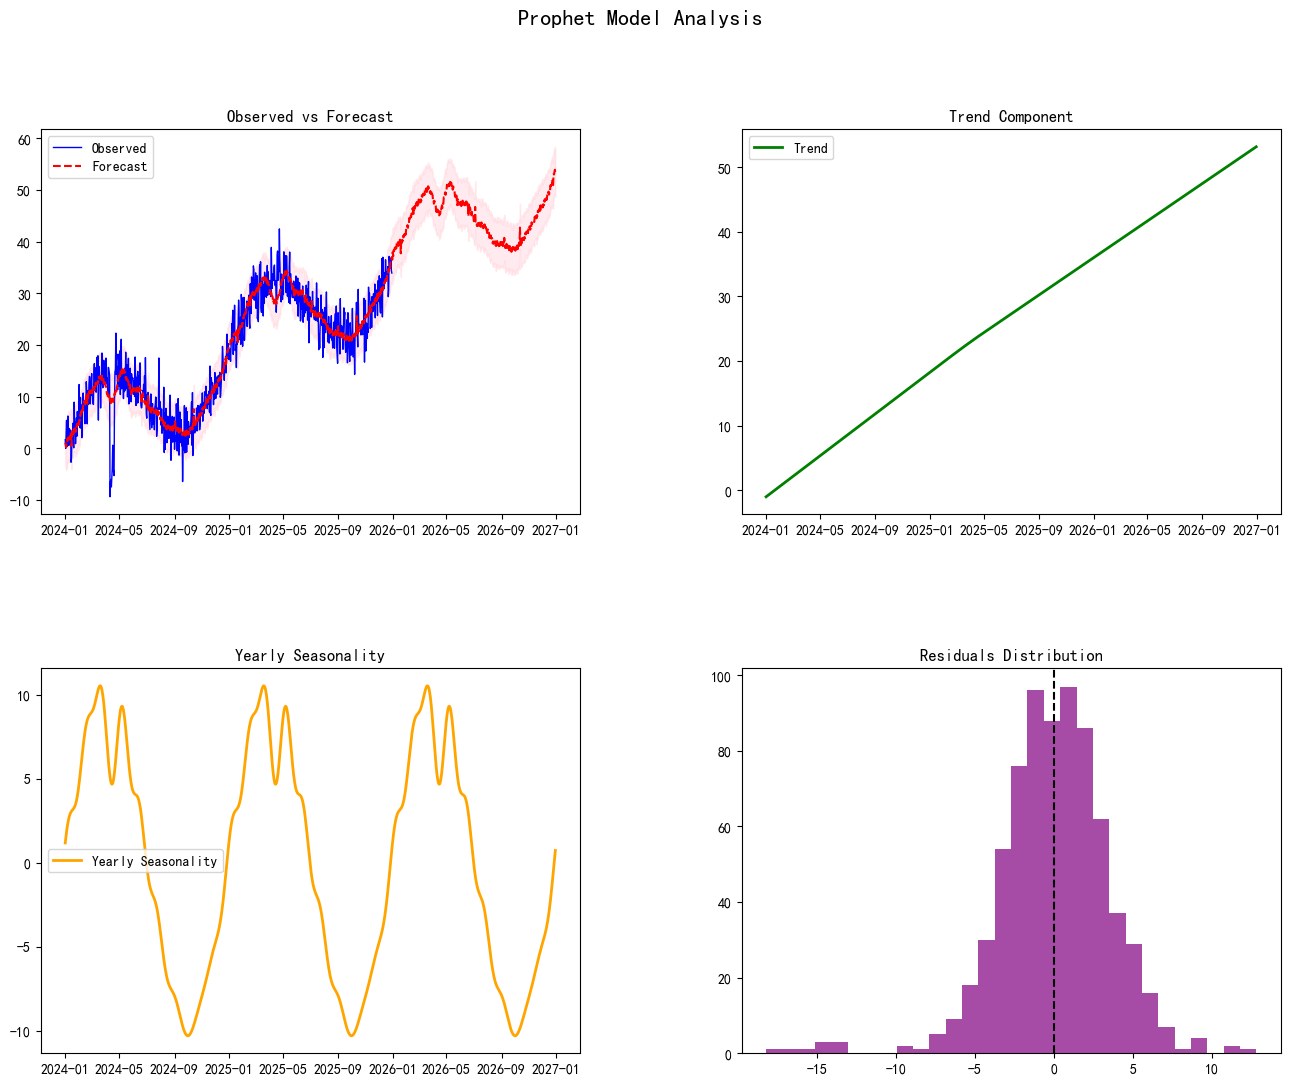

In [30]:
# 1. 创建虚拟数据集
np.random.seed(42)
dates = pd.date_range(start="2024-01-01", periods=365 * 2, freq='D')
trend = 0.05 * np.arange(len(dates))  # 长期趋势
seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365.25)  # 年周期
holiday_effect = np.zeros(len(dates))
holiday_effect[100:110] = -20  # 模拟一个节假日影响
noise = np.random.normal(0, 3, len(dates))  # 噪声
y = trend + seasonality + holiday_effect + noise

data = pd.DataFrame({"ds": dates, "y": y})

# 2. 建立并拟合 Prophet 模型
model = Prophet()
model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.add_country_holidays(country_name='US')  # 添加节假日
model.fit(data)

# 3. 生成未来预测
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# 4. 绘图
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

# 4.1 原始数据和预测结果:第一幅图展示了观测数据和预测值的拟合效果，便于直观评价模型预测性能。
axes[0, 0].plot(data['ds'], data['y'], label='Observed', color='blue', linewidth=1)
axes[0, 0].plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linestyle='--')
axes[0, 0].fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
axes[0, 0].set_title('Observed vs Forecast')
axes[0, 0].legend()

# 4.2 趋势分解:显示长期变化趋势，帮助理解宏观变化规律。
axes[0, 1].plot(forecast['ds'], forecast['trend'], label='Trend', color='green', linewidth=2)
axes[0, 1].set_title('Trend Component')
axes[0, 1].legend()

# 4.3 年季节性分解:揭示周期性波动，适合挖掘周期模式。
axes[1, 0].plot(forecast['ds'], forecast['yearly'], label='Yearly Seasonality', color='orange', linewidth=2)
axes[1, 0].set_title('Yearly Seasonality')
axes[1, 0].legend()

# 4.4 残差分析:评估模型的随机误差是否符合假设，检查是否存在系统偏差。
residuals = data['y'] - forecast.loc[:len(data) - 1, 'yhat'].values
axes[1, 1].hist(residuals, bins=30, color='purple', alpha=0.7)
axes[1, 1].set_title('Residuals Distribution')
axes[1, 1].axvline(0, color='black', linestyle='--')

plt.suptitle('Prophet Model Analysis', fontsize=16)
plt.show()

## 10. 时间卷积网络(Variational Autoencoders，VAE)

### 10.1 概念 
时间卷积网络是一种用于处理时序数据的深度学习架构。TCN 通过因果卷积和扩展卷积（也称空洞卷积）构造一个卷积网络，确保模型能够捕获长时间的依赖关系并保持序列的时间顺序。

### 10.2 TCN特点 
1. 因果卷积（Causal Convolution）：卷积操作只依赖于当前时间步及之前的时间步，确保信息不会“泄露”到未来。
2. 扩展卷积（Dilated Convolution）：通过引入扩展因子，使得卷积核可以在更大的时间范围内提取特征，同时避免增加模型复杂度。
3. 序列与序列映射：输入和输出的长度保持一致，避免信息丢失。
4. 残差连接（Residual Connection）：加速模型收敛并缓解梯度消失。

### 10.3 原理与核心公式 
1. **因果原理** 
因果卷积确保模型在预测时不使用未来信息。对于一个一维卷积核$k$ ，输出$y[\ t]$为：
$$y[\ t] = \sum_{i=0}^{k-1}w[\ i]\cdot x[\ t-i]$$
其中$x$是输入序列，$w$是卷积核权重。

2. **扩展卷积**
扩展卷积通过在卷积核之间引入间隙$d$（扩展因子）扩大感受野：
$$y[\ t ] = \sum_{i=0}^{k-1}w[\ i ]\cdot x[\ t -i \cdot d]$$
其中$d$控制感受野大小, d = 1,2,4,....通常随层数成指数增长。

3. **残差连接**
每一层输出$H(x)$是输入$x$和卷积层输出$F(x)$的加和：
$$H(\ x) = F(\ x) +x $$  
残差连接环节梯度消失问题。


### 10.4 TCN公式推导 
1. **单层输出公式**：
对于第$l$层的扩展卷积操作，假设输入为$x^{(l)}$，权重为$w^{(l)}$，扩展因子为$d^{(l)}$，则：
$$y^{(l)}[\ t] = \sum_{i = 0}^{k-1}w^{(\ l)}[\ i]\cdot [\ t-i \cdot d^{(l)}]$$

2. **残差连接公式**
若引入残差连接，输出更新为：
$$H^{(l)}(\ x) = F^{(l)}(\ x) + x$$

3. **多层堆叠感受野**
$R$为感受野大小，层数为$L$，卷积核大小为$k$,扩展因子为$d$，则感受野大小为：
$$R = 1 + (k -1) \cdot \sum_{l=0}^{L-1}d^{(l)}$$

### 10.5 Demo 

C:\Users\Yin\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([800, 99])) that is different to the input size (torch.Size([800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Yin\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([200, 99])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Train Loss: 0.5104, Test Loss: 0.5094
Epoch 2/50, Train Loss: 0.5102, Test Loss: 0.5093
Epoch 3/50, Train Loss: 0.5100, Test Loss: 0.5092
Epoch 4/50, Train Loss: 0.5101, Test Loss: 0.5093
Epoch 5/50, Train Loss: 0.5101, Test Loss: 0.5093
Epoch 6/50, Train Loss: 0.5101, Test Loss: 0.5093
Epoch 7/50, Train Loss: 0.5101, Test Loss: 0.5093
Epoch 8/50, Train Loss: 0.5101, Test Loss: 0.5093
Epoch 9/50, Train Loss: 0.5101, Test Loss: 0.5092
Epoch 10/50, Train Loss: 0.5100, Test Loss: 0.5092
Epoch 11/50, Train Loss: 0.5100, Test Loss: 0.5092
Epoch 12/50, Train Loss: 0.5100, Test Loss: 0.5092
Epoch 13/50, Train Loss: 0.5100, Test Loss: 0.5093
Epoch 14/50, Train Loss: 0.5100, Test Loss: 0.5093
Epoch 15/50, Train Loss: 0.5100, Test Loss: 0.5093
Epoch 16/50, Train Loss: 0.5100, Test Loss: 0.5093
Epoch 17/50, Train Loss: 0.5100, Test Loss: 0.5093
Epoch 18/50, Train Loss: 0.5099, Test Loss: 0.5093
Epoch 19/50, Train Loss: 0.5099, Test Loss: 0.5093
Epoch 20/50, Train Loss: 0.5099, Test Lo

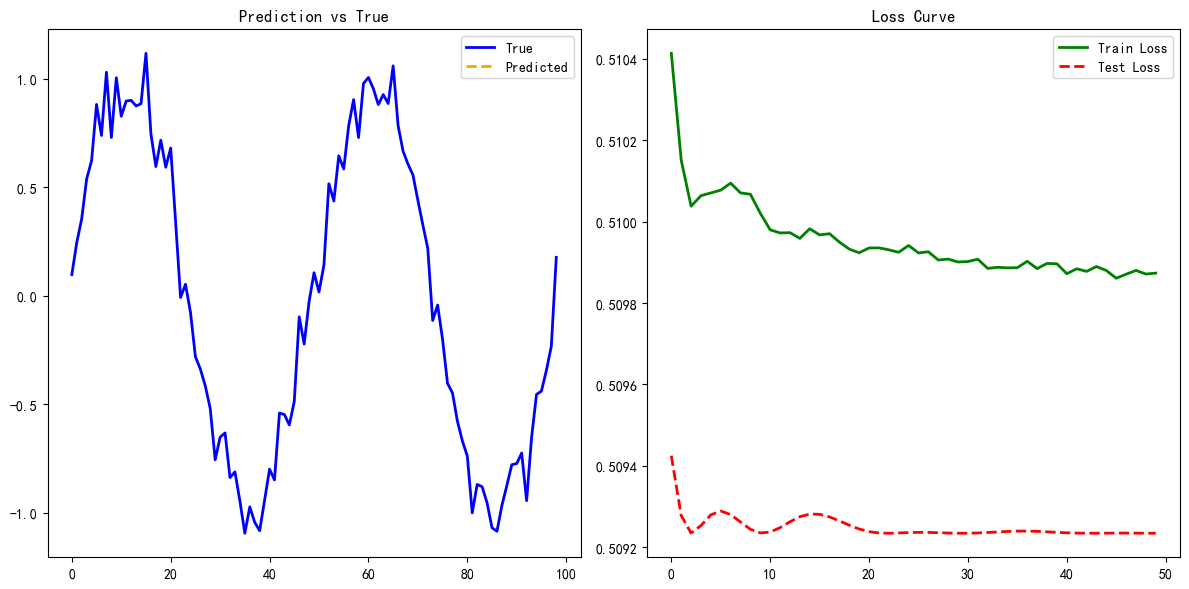

In [35]:
# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 创建虚拟时间序列数据
def generate_synthetic_data(seq_len, num_samples):
    x = np.linspace(0, 4 * np.pi, seq_len)
    data = []
    for _ in range(num_samples):
        noise = np.random.normal(0, 0.1, size=seq_len)
        data.append(np.sin(x) + noise)
    return np.array(data)

seq_len = 100
num_samples = 1000
data = generate_synthetic_data(seq_len, num_samples)

# 数据切分
train_data = data[:800]
test_data = data[800:]
x_train, y_train = train_data[:, :-1], train_data[:, 1:]
x_test, y_test = test_data[:, :-1], test_data[:, 1:]

# 转为 PyTorch Tensor
x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# 构建 TCN 模型
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        self.tcn = nn.ModuleList()
        for i in range(len(num_channels)):
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            self.tcn.append(nn.Conv1d(in_channels, out_channels, kernel_size, padding=(kernel_size-1)*2**i, dilation=2**i))
            self.tcn.append(nn.ReLU())
            self.tcn.append(nn.Dropout(dropout))
        self.fc = nn.Linear(num_channels[-1], output_size)
    
    def forward(self, x):
        for layer in self.tcn:
            x = layer(x)
        x = x.permute(0, 2, 1)  # 调整维度以便于全连接层
        x = self.fc(x[:, -1, :])  # 仅取最后时间步
        return x

# 初始化模型和优化器
model = TCN(input_size=1, output_size=1, num_channels=[16, 32, 64], kernel_size=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 数据格式调整
x_train = x_train.unsqueeze(1)  # 添加通道维度
x_test = x_test.unsqueeze(1)

# 训练模型
epochs = 50
train_losses, test_losses = [], []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    # 记录损失
    train_losses.append(loss.item())
    with torch.no_grad():
        model.eval()
        test_output = model(x_test)
        test_loss = criterion(test_output, y_test)
        test_losses.append(test_loss.item())
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# 预测结果可视化
with torch.no_grad():
    predictions = model(x_test).numpy()

# 可视化
plt.figure(figsize=(12, 6))

# 图 1：预测结果对比图:蓝线表示真实值，橙线表示预测值，通过比较两者的差异，可以评估模型的预测精度。
plt.subplot(1, 2, 1)
plt.plot(y_test[0].numpy(), label='True', color='blue', linewidth=2)
plt.plot(predictions[0], label='Predicted', color='orange', linestyle='dashed', linewidth=2)
plt.title('Prediction vs True')
plt.legend()

# 图 2：损失曲线图: 绿色线表示训练损失，红色线表示测试损失，直观展示模型的收敛情况及可能的过拟合现象。
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='green', linewidth=2)
plt.plot(test_losses, label='Test Loss', color='red', linestyle='dashed', linewidth=2)
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()